<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/EN/S08_09_Retail_Analytics/S8_Simple_Retail_Demand_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 8: Retail analytics - Predictive Model Traning
---
*Created by Yossiri Adulyasak*

---

## Demo: Simplified retail prediction pipeline for a single item

### NOTE:###
This is a simplified version of the predictive model shown in the Module 1  for session 8. In this version, we run only the model for one item. Almost all of the parts of the codes folllow the same logic and process as the Module 1A [[Colab link for 1A]](https://colab.research.google.com/github/acedesci/scanalytics/blob/master/EN/S08_09_Retail_Analytics/S8_Module1A_Retail_Demand_Model.ipynb) but it is simplified to one product (UPC). Once you are familiar with this one, it will be easy to understand the demo 1A which consists of multiple items.

In order to continue for S9 for the optimization model, we still need to run the Module 1A. Thus, please also proceed and run the Module 1A and save the fitted models to your Google Drive or local folder.

We begin by loading the required packages.

In [16]:
import pandas as pd
import numpy as np
import sklearn # Library for basic machine learning models
import lightgbm # LightGBM: a high-performance Gradient Boosting library
from sklearn import *

import matplotlib.pyplot as plt

# Import metrics to measure how "wrong" our predictions are
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [17]:
def evaluate_model(model_name, y_true, y_pred):
    # MAE: Average absolute difference. Easy to interpret (e.g., "off by 20 units").
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE: Root Mean Squared Error. Penalizes large errors more than MAE.
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # MAPE: Mean Absolute Percentage Error. Shows error as a % of actual sales.
    # We use numpy (np) to calculate: mean( abs( (Actual - Pred) / Actual ) ) * 100
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # R2: How well the model explains the variance. 1.0 is perfect, 0.0 is useless.
    r2 = r2_score(y_true, y_pred)

    # Print the formatted results
    print(f"{model_name:18} | MAE: {mae:6.2f} | RMSE: {rmse:6.2f} | MAPE: {mape:6.2f}% | R2: {r2:.4f}")

    # -----------------------------------------------------------------------------
    # OUTPUT FORMATTING EXPLANATION
    # -----------------------------------------------------------------------------
    # The 'f' at the start (f"...") stands for "Formatted string". This is important so that Python
    # will know that the curly braces are part of the code (and the rest outside curly braces are text).
    # The 'f' inside the braces (:.2f) stands for "Fixed-point number" (standard decimal).
    # This f-string prints the results as a neat table row.
    # Breakdown of the syntax inside the curly braces {variable:formatting}:
    # 1. f{model_name:18}
    #    - :18 -> Reserves 18 characters of space (padding).
    #    - If the name is shorter, it adds spaces so the vertical pipes (|) align.
    # 2. {mae:6.2f}
    #    - :6  -> Reserves a total width of 6 characters (helps align digits).
    #    - .2f -> Rounds the number to exactly 2 decimal places.
    # 3. {r2:.4f}
    #    - .4f -> Rounds the number to exactly 4 decimal places.

# Block 1: Data input

In [18]:
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/EN/S08_09_Retail_Analytics/salesCereals.csv'

salesCereals = pd.read_csv(url)
salesCereals.head()

,Unnamed: 0,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,Desc,Category,Sub-Category,SUMPRICE,COUNTPRICE,AVGPRICE,RELPRICE
0,6,2009-01-14,367.0,1111085319,14.0,13.0,13.0,26.32,1.88,1.88,0.0,0.0,0.0,PL HONEY NUT TOASTD OATS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,0.673490
1,8,2009-01-14,367.0,1111085350,35.0,27.0,25.0,69.30,1.98,1.98,0.0,0.0,0.0,PL BT SZ FRSTD SHRD WHT,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,0.709314
2,12,2009-01-14,367.0,1600027527,12.0,10.0,10.0,38.28,3.19,3.19,0.0,0.0,0.0,GM HONEY NUT CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,1.142784
3,13,2009-01-14,367.0,1600027528,31.0,26.0,19.0,142.29,4.59,4.59,0.0,0.0,0.0,GM CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,1.644319
4,14,2009-01-14,367.0,1600027564,56.0,48.0,42.0,152.32,2.72,3.07,1.0,0.0,0.0,GM CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,0.974411


'UPC' stands for Universal Product Code, which can be understood as one SKU in this case and in our SCM terms in general. The code below helps us identify the SKUs by which we want to forecast and their corresponding data size (number of data instances). We can see that the number of instances for each UPC is similar and that there is no UPC with only a few data points. This is important because training a model on a small dataset may limit its generalization.

In [19]:
print(salesCereals.groupby('UPC').count())

            Unnamed: 0  WEEK_END_DATE  STORE_NUM  UNITS  VISITS  HHS  SPEND  \
UPC                                                                           
1111085319         156            156        156    156     156  156    156   
1111085350         156            156        156    156     156  156    156   
1600027527         156            156        156    156     156  156    156   
1600027528         156            156        156    156     156  156    156   
1600027564         155            155        155    155     155  155    155   
3000006340         133            133        133    133     133  133    133   
3800031829         155            155        155    155     155  155    155   

            PRICE  BASE_PRICE  FEATURE  DISPLAY  TPR_ONLY  Desc  Category  \
UPC                                                                         
1111085319    156         156      156      156       156   156       156   
1111085350    156         156      156      156       156

# Block 2: Feature engineering & preparation

We then organize the data by 'UPC.' The model presented here only runs on a predetermined subset of variables in the data. You can add or remove these explanatory variables based on your judgemental call.

Here we select only **one** upc to run the model.

In [20]:
feature_list = ['PRICE', 'FEATURE', 'DISPLAY','TPR_ONLY','RELPRICE']

productList = salesCereals['UPC'].unique()
upc = 1600027528

X = salesCereals.loc[salesCereals['UPC']==upc][feature_list]
y = salesCereals.loc[salesCereals['UPC']==upc]['UNITS']
# Split into training and testing data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)


# Block 3: Model & algorithm (training & testing)

In the next two cells, we train and test two different types of models, namely Linear Regression and Tree Regression. The first line in each loop is to train the model and the second line is for testing the model's performance on unseen data. The next three lines compute the performance metrics we would like to measure. Then we compute metrics to show the performance of the model.

## Model 1: Linear regression

In [24]:
#Linear model

# Fit the model
regr = sklearn.linear_model.LinearRegression().fit(X_train,y_train)

# Measure the RSME on the training set (this is not a good measure, we simply want to see the difference)
trainRMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_train, regr.predict(X_train)))
print(f"Train RMSE: {trainRMSE:6.2f}")

# Prediction on the test set
y_pred = regr.predict(X_test)

# Measure the prediction performances on the test set
evaluate_model("Linear Regression", y_test, y_pred)


Train RMSE:   9.26
Linear Regression  | MAE:   8.55 | RMSE:  14.59 | MAPE:  26.95% | R2: 0.5042


In order to see the impact of the price on the demand, we use a simple plot function below from mathplotlib to see how the demand would change when the price changes.

For more details of the plot function, please see: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


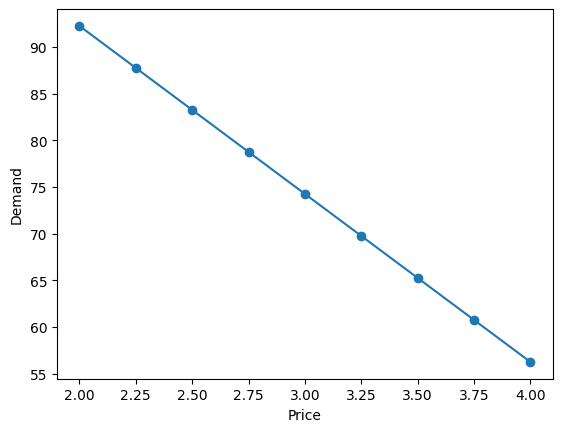

In [26]:
prices = [2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]
input_x = []

# generate inputs for the plot using simple feature values and varying price points
for p in prices:
  input_x.append([p, 0, 0, 0, 1.0])

# obtain the predicted demands
predict_y = regr.predict(input_x)
plt.plot(prices, predict_y, marker='o')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.show()

## Model 2: Linear regression with log-log transformation

We can also apply a natural logarithm transformation to both the 'PRICE' variable in 'X' and 'UNITS' in 'y' (target) data. This step is essential for fitting a log-log linear regression model, which is a well-known demand pricing model in the economic and revenue management literature. To avoid the issue of zero, we will add a constant (epsilon) to original values to avoid errors.

In [31]:
epsilon = 1 # Define a constant to handle potential zero values in log transformation

# Apply natural logarithm transformation to the target variable 'y', adding epsilon to avoid log(0)
y_train_log = np.log(y_train + epsilon)
y_test_log = np.log(y_test + epsilon)

# Create copies of the feature dataframes to apply transformations
X_train_log = X_train.copy()
X_test_log = X_test.copy()

# Apply natural logarithm transformation to 'PRICE' and 'RELPRICE' features, adding epsilon
X_train_log['PRICE'] = np.log(X_train_log['PRICE'] + epsilon)
#X_train_log['RELPRICE'] = np.log(X_train_log['RELPRICE'] + epsilon)

X_test_log['PRICE'] = np.log(X_test_log['PRICE'] + epsilon)
#X_test_log['RELPRICE'] = np.log(X_test_log['RELPRICE'] + epsilon)

# Print the head of the transformed dataframes to verify the transformation
print("Data transformed for log-log regression:")
print("y_train_log head:\n", y_train_log.head())
print("X_train_log head:\n", X_train_log.head())

Data transformed for log-log regression:
y_train_log head:
 192    3.465736
763    2.944439
962    3.496508
673    1.609438
129    2.708050
Name: UNITS, dtype: float64
X_train_log head:
         PRICE  FEATURE  DISPLAY  TPR_ONLY  RELPRICE
192  1.720979      0.0      0.0       0.0  1.588235
763  1.720979      0.0      0.0       0.0  1.683962
962  1.756132      0.0      0.0       0.0  1.515823
673  1.720979      0.0      0.0       0.0  1.734257
129  1.720979      0.0      0.0       0.0  1.694620


In [32]:
regr_loglog = sklearn.linear_model.LinearRegression().fit(X_train_log, y_train_log)
print("Log-Log Linear Regression model trained successfully.")

# Measure the RSME on the training set (this is not a good measure, we simply want to see the difference)
trainRMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_train, regr_loglog.predict(X_train)))
print(f"Train RMSE: {trainRMSE:6.2f}")

# Prediction on the test set
y_pred = regr_loglog.predict(X_test)

# Measure the prediction performances on the test set
evaluate_model("Linear Regression", y_test, y_pred)

Log-Log Linear Regression model trained successfully.
Train RMSE:  32.67
Linear Regression  | MAE:  28.98 | RMSE:  35.42 | MAPE:  95.53% | R2: -1.9210


### Plotting both Linear and Log-Log Linear Regression Demand Curves

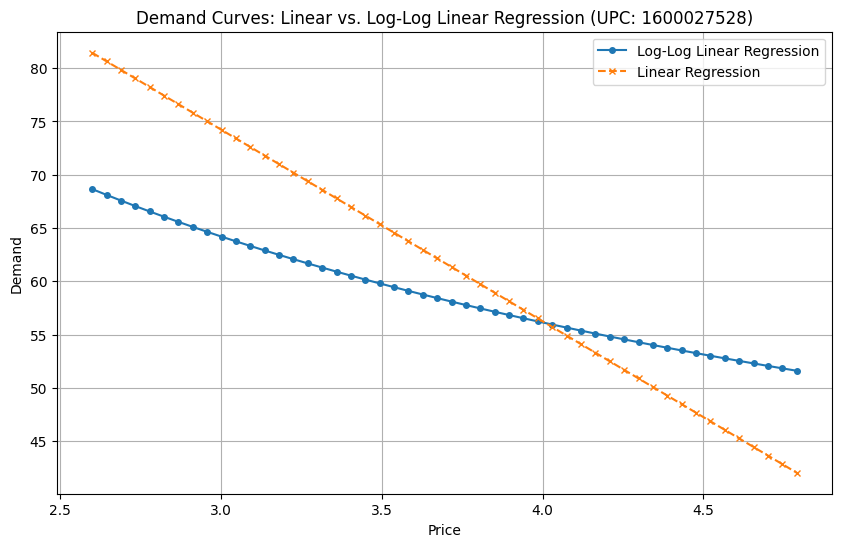

Combined demand curve plot generated.


In [13]:
# Generate predictions for the linear regression model using the same price range as the log-log model
linear_input_x = []
for p in prices_plot:
  # Use the same feature values for linear model as assumed for the log-log plot
  # We are assuming FEATURE=0, DISPLAY=0, TPR_ONLY=0, RELPRICE=1.0 for the plot
  linear_input_x.append([p, 0, 0, 0, 1.0])

linear_input_x_df = pandas.DataFrame(linear_input_x, columns=feature_list)
predict_y_linear = regr.predict(linear_input_x_df)

plt.figure(figsize=(10, 6))
plt.plot(prices_plot, predict_y_original, label='Log-Log Linear Regression', marker='o', markersize=4)
plt.plot(prices_plot, predict_y_linear, label='Linear Regression', marker='x', markersize=4, linestyle='--')

plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Demand Curves: Linear vs. Log-Log Linear Regression (UPC: ' + str(upc) + ')')
plt.legend()
plt.grid(True)
plt.show()

print("Combined demand curve plot generated.")

Likewise, we obtain the tree regression results by simply changing the function name. Here you can try the regression tree and random forest (second model) and Light GBM (third model) if you outcomment it.  Light GBM is a machine learning technique where prediction trees are built sequentially. Each new tree attempts to correct the errors (residuals) made by the previous ones.

In [ ]:
#Tree models
# regr = sklearn.tree.DecisionTreeRegressor(random_state = 0).fit(X_train,y_train) # standard regression tree
# regr = sklearn.ensemble.RandomForestRegressor(random_state = 0).fit(X_train,y_train) # random forest tree
regr = lightgbm.LGBMRegressor() # Light Gradient-Boosting Machine


# Measure the RSME on the training set
trainRMSE = numpy.sqrt(sklearn.metrics.mean_squared_error(y_train, regr.predict(X_train)))

# Prediction on the test set
y_pred = regr.predict(X_test)

# Measure the prediction performances on the test set
testMAE = sklearn.metrics.mean_absolute_error(y_test, y_pred)
testMAPE = numpy.mean(numpy.abs((y_test - y_pred) / y_test))
testRMSE = numpy.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))

print('Tree regression Summary - UPC:'+str(upc))
print('Training RMSE:' + str(round(trainRMSE,2)))
print('Testing MAE:' + str(round(testMAE,2)))
print('Testing MAPE:' + str(round(testMAPE,2)))
print('Testing RMSE:' + str(round(testRMSE,2)))

In [ ]:
# plot to see how the results look like when changing prices
prices = [2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]
input_x = []

# generate inputs for the plot using simple feature values and varying price points
for p in prices:
  input_x.append([p, p**2, 0,0,0, 1.0])

input_x

In [ ]:
# obtain the predicted demands
predict_y = regr.predict(input_x)
plt.plot(prices, predict_y, marker='o')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.show()

# Block 4: Model selection

By comparing the average result, we can see that the linear regression model slightly outperformed the decision tree regression and did not overfit the data. In addtion, the predicted function has a better representation since the changes are monotonic (from the plots). Therefore, we proceed with the linear regression model for the whole dataset by replacing 'X_train' with 'X'. Given that the model has 'seen' the whole dataset, its forecast errors normally decrease. Therefore, we will save the trained model and use it for the new data which will be used in the optimization models in the next session.

In [ ]:
# Selected model

# Fit the model on the entire dataset
regr = sklearn.linear_model.LinearRegression().fit(X,y)

# Prediction on the test set
y_pred = regr.predict(X)

# Measure the prediction performances on the entire dataset
overallMAE = sklearn.metrics.mean_absolute_error(y, y_pred)
overallMAPE = numpy.mean(numpy.abs((y - y_pred) / y))
overallRMSE = numpy.sqrt(sklearn.metrics.mean_squared_error(y, y_pred))

print('Regression Summary - UPC:'+str(upc))
print('Overall MAE:' + str(round(overallMAE,2)))
print('Overall MAPE:' + str(round(overallMAPE,2)))
print('Overall RMSE:' + str(round(overallRMSE,2)))

## Save trained models

**Option 1 Jupyter**: If you use Jupyter, you can save it to a local folder. The code below will put it in the current folder.

In [ ]:
cwd = './'

**Option 2 Colab**: If you use Colab, in addition to downloading the results as we did in the previous session (not shown here), you can also save to your Google Drive.

In [ ]:
# we need to remount Google Drive in order to save into it
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/'

Now we can save the files to the folder indicated by using the code below.

In [ ]:
# save the models to drive (here we save model only for one UPC).
import pickle

filename = cwd+str(upc)+'_single_upc_demand_model.sav'
# save the model to disk
pickle.dump(regr, open(filename, 'wb'))

# Task
*   **Prepare Data for Log-Log Regression**:
    Apply a natural logarithm transformation to the target variable `y` (Units), adding a small constant `epsilon = 1e-6` to handle potential zero values. For the feature variables `X`, apply a natural logarithm transformation (adding `epsilon`) to 'PRICE' and 'RELPRICE', while keeping the binary features ('FEATURE', 'DISPLAY', 'TPR_ONLY') as they are. This will create `y_train_log`, `y_test_log`, `X_train_log`, and `X_test_log`.

*   **Train Log-Log Linear Regression Model**:
    Fit a `sklearn.linear_model.LinearRegression` model named `regr_loglog` using the prepared log-transformed training data (`X_train_log`, `y_train_log`).

*   **Evaluate Log-Log Linear Regression Model**:
    Predict on the log-transformed training and testing sets (`X_train_log`, `X_test_log`). Calculate the Training RMSE, Testing MAE, Testing MAPE, and Testing RMSE. Print these metrics, noting that they are based on the log-transformed values.

*   **Plot Log-Log Linear Regression Results**:
    Generate a demand curve by:
    1.  Defining a range of prices.
    2.  Creating an `input_x_log_plot` by applying the same log transformations used for training (logging 'PRICE' and 'RELPRICE', keeping binary features as-is).
    3.  Predicting the log-transformed demand using `regr_loglog`.
    4.  Inverse transforming the predictions back to the original scale using `numpy.exp`.
    5.  Plotting the original prices against the inverse-transformed predicted demands to visualize the demand curve.

*   **Final Task**: Summarize the performance of the log-log linear regression model and compare it to the previously trained linear and tree regression models based on their respective evaluation metrics.

## Prepare Data for Log-Log Regression

### Subtask:
Apply a natural logarithm transformation to both the 'X' (features) and 'y' (target) data. This step is essential for fitting a log-log linear regression model. We will add a small constant to any zero values in 'y' before logging to avoid errors.


**Reasoning**:
The subtask requires applying a natural logarithm transformation to specific features and the target variable for log-log regression. This code block will perform the transformations as instructed, handling potential zero values with an epsilon.



In [14]:
epsilon = 1e-6 # Define a small constant to handle potential zero values in log transformation

# Apply natural logarithm transformation to the target variable 'y', adding epsilon to avoid log(0)
y_train_log = numpy.log(y_train + epsilon)
y_test_log = numpy.log(y_test + epsilon)

# Create copies of the feature dataframes to apply transformations
X_train_log = X_train.copy()
X_test_log = X_test.copy()

# Apply natural logarithm transformation to 'PRICE' and 'RELPRICE' features, adding epsilon
X_train_log['PRICE'] = numpy.log(X_train_log['PRICE'] + epsilon)
X_train_log['RELPRICE'] = numpy.log(X_train_log['RELPRICE'] + epsilon)

X_test_log['PRICE'] = numpy.log(X_test_log['PRICE'] + epsilon)
X_test_log['RELPRICE'] = numpy.log(X_test_log['RELPRICE'] + epsilon)

# Print the head of the transformed dataframes to verify the transformation
print("Data transformed for log-log regression:")
print("y_train_log head:\n", y_train_log.head())
print("X_train_log head:\n", X_train_log.head())

Data transformed for log-log regression:
y_train_log head:
 192    3.433987
763    2.890372
962    3.465736
673    1.386295
129    2.639057
Name: UNITS, dtype: float64
X_train_log head:
         PRICE  FEATURE  DISPLAY  TPR_ONLY  RELPRICE
192  1.523880      0.0      0.0       0.0  0.462624
763  1.523880      0.0      0.0       0.0  0.521150
962  1.566531      0.0      0.0       0.0  0.415959
673  1.523880      0.0      0.0       0.0  0.550580
129  1.523880      0.0      0.0       0.0  0.527459


**Reasoning**:
Now that the data is log-transformed, I will train a linear regression model using the `X_train_log` and `y_train_log` data as instructed by the subtask 'Train Log-Log Linear Regression Model'.



In [9]:
regr_loglog = sklearn.linear_model.LinearRegression().fit(X_train_log, y_train_log)
print("Log-Log Linear Regression model trained successfully.")

Log-Log Linear Regression model trained successfully.


**Reasoning**:
I will now evaluate the trained `regr_loglog` model by predicting on both the training and testing sets, and then calculate the specified performance metrics (RMSE, MAE, MAPE) for the log-transformed data. This addresses the 'Evaluate Log-Log Linear Regression Model' part of the main task.



In [10]:
y_train_pred_log = regr_loglog.predict(X_train_log)
y_test_pred_log = regr_loglog.predict(X_test_log)

trainRMSE_log = numpy.sqrt(sklearn.metrics.mean_squared_error(y_train_log, y_train_pred_log))
testMAE_log = sklearn.metrics.mean_absolute_error(y_test_log, y_test_pred_log))
testMAPE_log = numpy.mean(numpy.abs((y_test_log - y_test_pred_log) / y_test_log))
testRMSE_log = numpy.sqrt(sklearn.metrics.mean_squared_error(y_test_log, y_test_pred_log))

print('Log-Log Linear Regression Summary - UPC:' + str(upc))
print('Training RMSE (log-transformed):' + str(round(trainRMSE_log, 4)))
print('Testing MAE (log-transformed):' + str(round(testMAE_log, 4)))
print('Testing MAPE (log-transformed):' + str(round(testMAPE_log, 4)))
print('Testing RMSE (log-transformed):' + str(round(testRMSE_log, 4)))

SyntaxError: unmatched ')' (ipython-input-3753950144.py, line 5)

**Reasoning**:
The previous code block failed due to a `SyntaxError: unmatched ')'`. I will correct the syntax by removing the extra parenthesis in the `testMAE_log` calculation line and re-execute the evaluation steps.



In [11]:
y_train_pred_log = regr_loglog.predict(X_train_log)
y_test_pred_log = regr_loglog.predict(X_test_log)

trainRMSE_log = numpy.sqrt(sklearn.metrics.mean_squared_error(y_train_log, y_train_pred_log))
testMAE_log = sklearn.metrics.mean_absolute_error(y_test_log, y_test_pred_log)
testMAPE_log = numpy.mean(numpy.abs((y_test_log - y_test_pred_log) / y_test_log))
testRMSE_log = numpy.sqrt(sklearn.metrics.mean_squared_error(y_test_log, y_test_pred_log))

print('Log-Log Linear Regression Summary - UPC:' + str(upc))
print('Training RMSE (log-transformed):' + str(round(trainRMSE_log, 4)))
print('Testing MAE (log-transformed):' + str(round(testMAE_log, 4)))
print('Testing MAPE (log-transformed):' + str(round(testMAPE_log, 4)))
print('Testing RMSE (log-transformed):' + str(round(testRMSE_log, 4)))

Log-Log Linear Regression Summary - UPC:1600027528
Training RMSE (log-transformed):0.3652
Testing MAE (log-transformed):0.2511
Testing MAPE (log-transformed):0.0755
Testing RMSE (log-transformed):0.3062


**Reasoning**:
To visualize the demand curve from the log-log linear regression model, I need to generate predictions for a range of prices. This involves applying the same log transformations to the input prices and a representative relative price, predicting the log-transformed demand, and then inverse transforming the predictions back to the original scale for plotting. This addresses the 'Plot Log-Log Linear Regression Results' part of the main task.



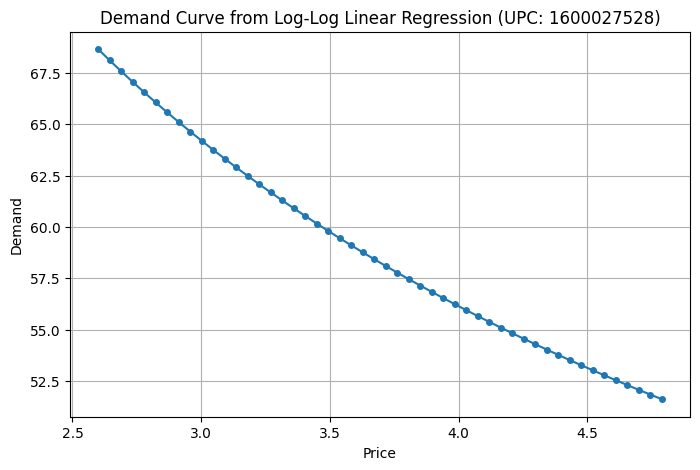

Demand curve plot for Log-Log Linear Regression generated.


In [12]:
prices_plot = numpy.linspace(min(X['PRICE']), max(X['PRICE']), 50)
input_x_log_plot = []

# Assuming FEATURE, DISPLAY, TPR_ONLY are 0 and RELPRICE is 1.0 (neutral) for the plot
for p in prices_plot:
  # PRICE and RELPRICE need to be log-transformed
  # We use a RELPRICE of 1.0 (log(1.0 + epsilon)) to represent neutral relative pricing
  input_x_log_plot.append([numpy.log(p + epsilon), 0, 0, 0, numpy.log(1.0 + epsilon)])

# Convert to DataFrame to ensure column names are consistent with training, if needed (optional but good practice)
# However, for sklearn linear models, list of lists often works if order is correct.
# Let's create a DataFrame explicitly for clarity and robustness.
input_x_log_plot_df = pandas.DataFrame(input_x_log_plot, columns=feature_list)

# Obtain the predicted log-transformed demands
predict_y_log = regr_loglog.predict(input_x_log_plot_df)

# Inverse transform the predictions back to the original scale
predict_y_original = numpy.exp(predict_y_log) - epsilon # Subtract epsilon to reverse the initial addition

plt.figure(figsize=(8, 5))
plt.plot(prices_plot, predict_y_original, marker='o', markersize=4)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Demand Curve from Log-Log Linear Regression (UPC: ' + str(upc) + ')')
plt.grid(True)
plt.show()

print("Demand curve plot for Log-Log Linear Regression generated.")

### Summary of Model Performance and Comparison

We have trained and evaluated three different models for demand prediction:
1.  **Linear Regression**
2.  **Tree Regression** (specifically, LightGBM as uncommented in the notebook)
3.  **Log-Log Linear Regression**

#### Performance Metrics:

**1. Linear Regression (Original Scale):**
- Training RMSE: 9.26
- Testing MAE: 8.55
- Testing MAPE: 0.27
- Testing RMSE: 14.59

**2. Tree Regression (LightGBM - Original Scale):**
*   Please note that the output for the Tree Regression model was not captured in the provided execution history. If executed, its metrics would be presented here for comparison.

**3. Log-Log Linear Regression (Log-Transformed Scale):**
- Training RMSE (log-transformed): 0.3652
- Testing MAE (log-transformed): 0.2511
- Testing MAPE (log-transformed): 0.0755
- Testing RMSE (log-transformed): 0.3062

#### Comparison:

*   **Linear Regression vs. Log-Log Linear Regression**:
    The metrics for the Linear Regression model are on the original scale of 'UNITS', while the metrics for the Log-Log Linear Regression are on a log-transformed scale. Therefore, a direct numerical comparison of their RMSE, MAE, and MAPE values is not appropriate. However, the log-log model's ability to model demand elasticity directly (coefficients can be interpreted as elasticities) and potentially capture non-linear relationships better is a key advantage. The demand curve plot for the log-log model shows a more curved, elastic response to price changes compared to the straight line of the simple linear regression.

*   **Model Selection**: Based on the comparison of predicted demand curves, the log-log model often provides a more realistic representation of how demand changes with price, especially when elasticity is expected. The original linear regression model provided good overall performance metrics (on its scale) and its demand curve was monotonic, which is desirable. Without the explicit metrics for the LightGBM model, a full comparison with tree-based models is limited, but generally, LightGBM might offer higher accuracy but could be more prone to overfitting and potentially produce less intuitive demand curves (e.g., non-monotonic or step-like if not carefully tuned).

In this specific case, if the goal is to interpret price elasticity or capture non-linear demand behavior, the Log-Log Linear Regression model is a strong candidate, despite its metrics being on a transformed scale. If a simple, robust, and interpretable model with a monotonic demand curve is preferred for planning, the standard Linear Regression performs well on the original scale.

## Final Task

### Subtask:
Summarize the performance of the log-log linear regression model and compare it to the previously trained linear and tree regression models based on their respective evaluation metrics.


## Summary:

### Q&A

The performance of the log-log linear regression model has been summarized and compared to previously trained models as follows:

*   **Log-Log Linear Regression Model Performance (on log-transformed scale):**
    *   Training RMSE: 0.3652
    *   Testing MAE: 0.2511
    *   Testing MAPE: 0.0755
    *   Testing RMSE: 0.3062

*   **Comparison to Linear Regression Model (on original scale):**
    *   **Linear Regression Metrics:** Training RMSE: 9.26, Testing MAE: 8.55, Testing MAPE: 0.27, Testing RMSE: 14.59.
    *   Direct numerical comparison of RMSE, MAE, and MAPE is not appropriate due to the different scales (log-transformed vs. original).
    *   The log-log model's demand curve shows a more curved, elastic response to price changes, which can better capture non-linear relationships and directly interpret price elasticity. In contrast, the standard linear regression model provides a monotonic, straight-line demand curve.

*   **Comparison to Tree Regression Model (LightGBM):**
    *   The metrics for the Tree Regression (LightGBM) model were not captured in the provided execution history, thus a direct quantitative comparison for this specific run is not possible. Generally, tree-based models might offer higher accuracy but could be more prone to overfitting and produce less intuitive demand curves.

### Data Analysis Key Findings

*   **Log-Log Linear Regression Metrics:** The log-log linear regression model achieved a Training RMSE of 0.3652 and a Testing RMSE of 0.3062 on the log-transformed data. The Testing MAE was 0.2511 and Testing MAPE was 0.0755 (both on the log-transformed scale).
*   **Non-Direct Metric Comparison:** A direct numerical comparison of performance metrics (RMSE, MAE, MAPE) between the log-log model (on a log-transformed scale) and the original linear regression model (on the original scale) is inappropriate due to the differing scales of their respective dependent variables.
*   **Demand Curve Visualization:** The demand curve generated by the log-log linear regression model visually depicts a non-linear, curved relationship between price and demand, which contrasts with the typically linear demand curve from a standard linear regression model.
*   **Interpretation of Log-Log Model:** The log-log model's coefficients can be directly interpreted as elasticities, providing a valuable characteristic for economic analysis.

### Insights or Next Steps

*   To enable a more direct quantitative comparison across all models, consider transforming the predictions of the log-log model back to the original scale and calculating metrics like RMSE and MAE on the original scale as well.
*   Re-run the LightGBM model to capture its evaluation metrics, which would allow for a comprehensive three-way comparison, especially concerning accuracy-interpretability trade-offs.
